https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [59]:
import pandas as pd
import numpy as np
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

ImportError: module print_evaluation_metrics not in sys.modules

Load dataset and prepare df

In [19]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [20]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Tune model

In [21]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

20:53:29 - cmdstanpy - INFO - Chain [1] start processing
20:53:29 - cmdstanpy - INFO - Chain [1] done processing


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Op

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [22]:
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [23]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation



20:57:51 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
pred = auto_model.predict(test[['ds']])

In [69]:
non_zero = []
 
for i in pred['yhat']:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)
print_evaluation_metrics(non_zero, test['y']-1, train['y']-1)

Evaluation Metrics:
MSE: 1536612.38
RMSE: 1239.60
MAE: 1100.94
MAPE: 285.31
SMAPE: 190.87
MASE: 0.64


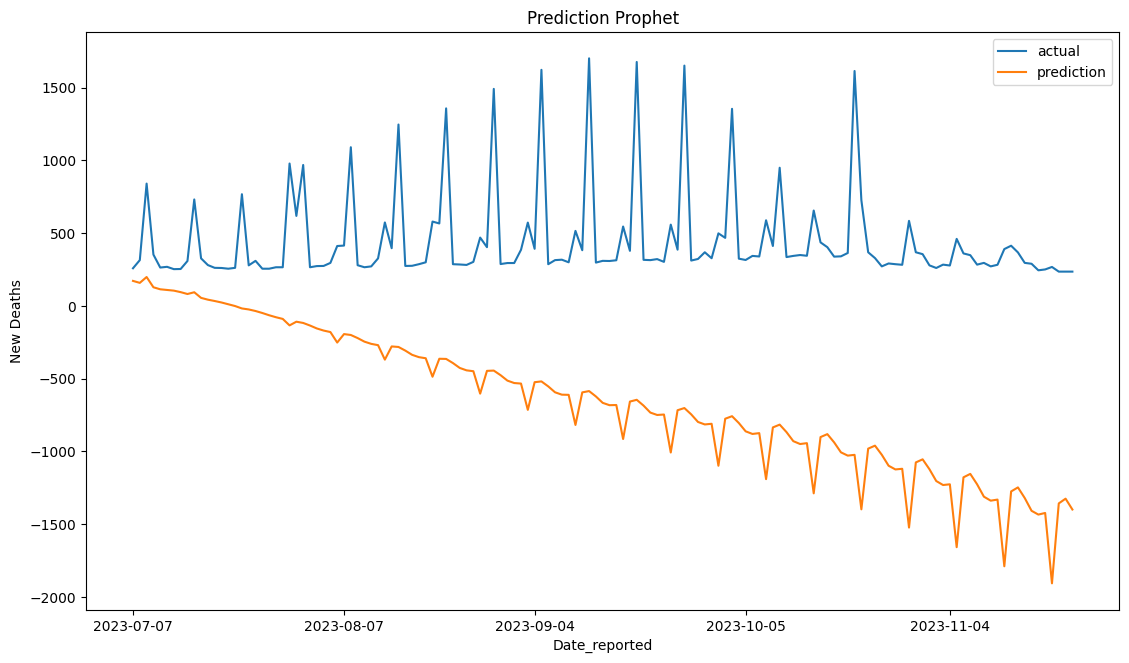

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], (test['y']-1).values, label="actual")
ax.plot(test['ds'], non_zero, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [27]:
store_model(auto_model, "prophet")

In [44]:
# Create a copy of the data
data_log = train.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2020-02-02,0,5.834811
1,2020-02-03,0,5.703782
2,2020-02-04,0,5.713733
3,2020-02-05,0,5.730100
4,2020-02-06,0,5.723585


In [45]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive'}

In [46]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation

21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:54 - cmdstanpy - INFO - Chain [1] start processing
21:

21:23:54 - cmdstanpy - INFO - Chain [1] done processing
21:23:54 - cmdstanpy - INFO - Chain [1] start processing
21:23:54 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  1.748154  1.322178  1.192015  0.152824  0.148519  0.139676   

   coverage  
0  0.208046  


21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.031382  1.425265  1.267068  0.161601  0.156961  0.146839   

   coverage  
0  0.217241  


21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:18 - cmdstanpy - INFO - Chain [1] done processing
21:24:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] done processing
21:24:19 - cmdstanpy - INFO - Chain [1] done processing
21:

  horizon       mse      rmse     mae      mape     mdape     smape  coverage
0 30 days  1.891625  1.375363  1.2461  0.159159  0.155739  0.145158  0.186207


21:24:30 - cmdstanpy - INFO - Chain [1] start processing
21:24:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  2.122338  1.456825  1.290347  0.163834  0.15759  0.148792  0.204598


21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] done processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] done processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] done processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  1.863375  1.365055  1.23477  0.157658  0.153151  0.143888  0.194253


21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.186357  1.478634  1.307386  0.165843  0.160431  0.150385   

   coverage  
0  0.202299  


21:25:02 - cmdstanpy - INFO - Chain [1] start processing
21:25:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  1.848093  1.359446  1.22944  0.157196  0.153607  0.143485  0.188506


21:25:13 - cmdstanpy - INFO - Chain [1] start processing
21:25:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21

  horizon       mse    rmse       mae      mape     mdape     smape  coverage
0 30 days  2.230244  1.4934  1.325341  0.167847  0.165327  0.152182  0.196552


21:25:21 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  1.829973  1.352765  1.222645  0.156269  0.15335  0.142713  0.193103


21:25:33 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] done processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] done processing
21:25:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
21:25:35 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.203399  1.484385  1.312902  0.166492  0.163245  0.150953   

   coverage  
0  0.198851  


21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.346308  0.588479  0.442729  0.055873  0.040894  0.054865   

   coverage  
0  0.424138  


21:25:51 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] done processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.391431  0.625645  0.475009  0.060243  0.047416  0.059002   

   coverage  
0  0.374713  


21:25:57 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.407748  0.638552  0.478288  0.059986  0.044163  0.059022   

   coverage  
0  0.390805  


21:26:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:06 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.514159  0.717049  0.513726  0.064346  0.045781  0.063051   

   coverage  
0  0.398851  


21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.407433  0.638305  0.479917  0.060204  0.044783  0.05928  0.383908


21:26:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.515301  0.717844  0.512451  0.064118  0.045702  0.062829   

   coverage  
0  0.401149  


21:26:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] done processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] done processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.402777  0.634647  0.476934  0.059812  0.04582  0.058847  0.390805


21:26:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:25 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done

  horizon       mse    rmse       mae      mape     mdape     smape  coverage
0 30 days  0.512942  0.7162  0.512742  0.064209  0.046082  0.062959  0.405747


21:26:29 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.400231  0.632638  0.475508  0.059718  0.044327  0.058735   

   coverage  
0  0.386207  


21:26:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.505121  0.710719  0.508842  0.06377  0.046243  0.062499  0.417241


21:26:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape    mdape    smape  coverage
0 30 days  0.321071  0.566632  0.422812  0.053425  0.03898  0.05259  0.417241


21:26:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.338986  0.582225  0.436956  0.055596  0.041803  0.05454  0.382759


21:26:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.375864  0.613078  0.453185  0.056885  0.039587  0.056056   

   coverage  
0       0.4  


21:26:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:51 - cmdstanpy - INFO - Chain [1] start processing
21:26:51 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape   mdape   smape  coverage
0 30 days  0.460251  0.678418  0.486867  0.061167  0.0423  0.0599  0.388506


21:26:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.391689  0.625851  0.460051  0.057657  0.04011  0.056922  0.409195


21:27:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] done processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] star

  horizon     mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.4636  0.680882  0.489443  0.061484  0.043841  0.060193  0.382759


21:27:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.383871  0.619573  0.458158  0.057387  0.040278  0.056608   

   coverage  
0  0.393103  


21:27:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.468967  0.684812  0.493586  0.062043  0.044101  0.060694   

   coverage  
0  0.368966  


21:27:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.403168  0.634955  0.468264  0.058615  0.040553  0.058035   

   coverage  
0  0.386207  


21:27:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.468273  0.684305  0.489062  0.061443  0.042288  0.060124   

   coverage  
0  0.385057  


21:27:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] st

  horizon      mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.24438  0.494348  0.339656  0.04364  0.028357  0.042969  0.568966


21:27:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] st

  horizon       mse   rmse       mae      mape     mdape     smape  coverage
0 30 days  0.249001  0.499  0.349321  0.045542  0.030163  0.044737  0.521839


21:27:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] done processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.324776  0.569891  0.390668  0.04961  0.031987  0.048902  0.501149


21:27:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing
21:27:40 - cmdstanpy - INFO - Chain [1] do

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.617042  0.78552  0.553769  0.068496  0.048534  0.067926  0.374713


21:27:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.319728  0.565445  0.387726  0.049349  0.031736  0.048641   

   coverage  
0  0.497701  


21:27:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] st

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.64121  0.800756  0.561593  0.069246  0.048278  0.068789  0.382759


21:27:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.311577  0.558191  0.385215  0.049106  0.032568  0.048437   

   coverage  
0  0.491954  


21:28:04 - cmdstanpy - INFO - Chain [1] start processing
21:28:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.636516  0.797819  0.564976  0.069589  0.049141  0.069046   

   coverage  
0  0.370115  


21:28:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.306534  0.553656  0.377974  0.048265  0.030697  0.047587   

   coverage  
0  0.513793  


21:28:17 - cmdstanpy - INFO - Chain [1] start processing
21:28:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:28:18 - cmdstanpy - INFO - Chain [1] start processing
21:28:18 - cmdstanpy - INFO - Chain [1] start processing
21:28:18 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:19 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.632373  0.795219  0.56271  0.069512  0.050055  0.069089  0.373563
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


21:28:25 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive'}

In [64]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [65]:
non_zero = []
for i in pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)
print_evaluation_metrics(non_zero, test['y']-1, train['y']-1)

Evaluation Metrics:
MSE: 135566.48
RMSE: 368.19
MAE: 191.07
MAPE: 33.15
SMAPE: 39.01
MASE: 0.11


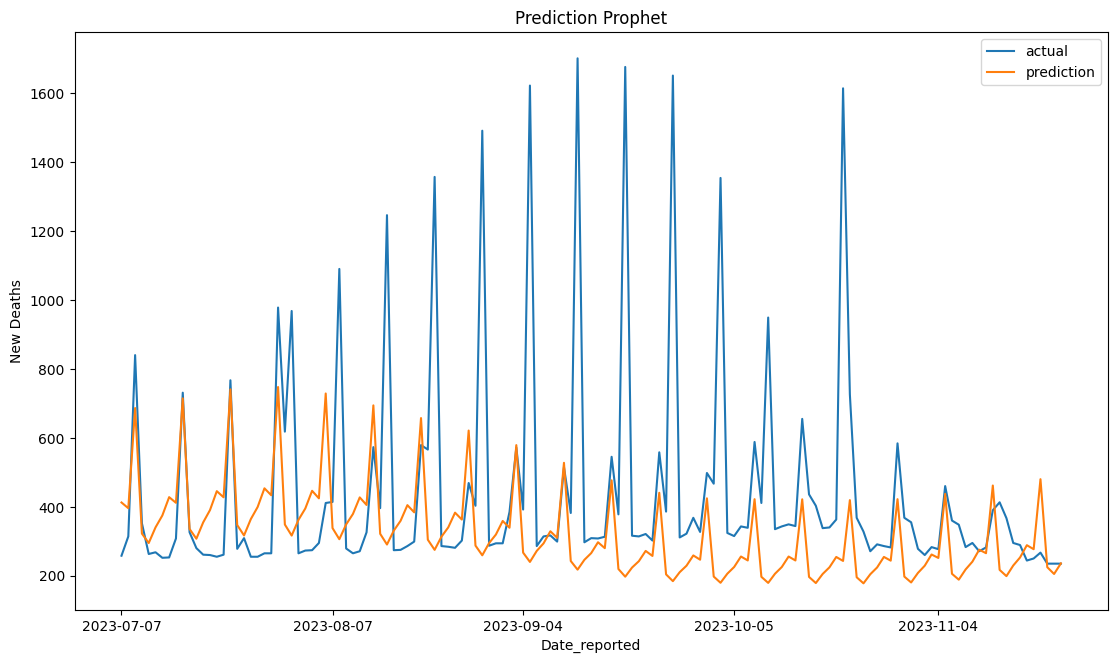

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], (test['y']-1).values, label="actual")
ax.plot(test['ds'], non_zero, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [54]:
store_model(auto_model_log, "prophet_log")